In [1]:
import tensorflow as tf
import numpy as np
import librosa as li
import matplotlib.pyplot as plt
import IPython.display as ipd
import time
from concurrent.futures import ThreadPoolExecutor
from preprocessing import Audio

%matplotlib inline
GPU = tf.config.list_physical_devices('GPU')
CPU = tf.config.list_physical_devices('CPU')
DEVICE = GPU[0].name if GPU else CPU[0].name
DEVICE

'/physical_device:GPU:0'

In [2]:
def to_len(y, sec=1.0, sr=44100):
    y, _ = li.effects.trim(y)
    x = tf.keras.preprocessing.sequence.pad_sequences(
        [y],
        maxlen=int(sr * sec),
        padding='post',
        truncating='post',
        dtype='float32'
    )[0]
    return x

In [3]:
def get_audio(path):
    audio = Audio(path)
#     augmented = audio.augmented_source()
    augmented = [audio.data]
    data = list(map(to_len, augmented))
    labels = [audio.label] * len(augmented)
    return [data, labels]

In [4]:
def get_labeled_data(nums=1500):
    FALSE_DATA = 'AudioData/0 Данные'
    NOISE = 'AudioData/0 Шум'
    JARVIS = 'AudioData/1 Джарвис'
    DIO = 'AudioData/2 Дио'
    ITAN = 'AudioData/3 Итан'
    LADA = 'AudioData/4 Лада'
    MIRA = 'AudioData/5 Мира'
    
    p = li.util.find_files(FALSE_DATA)
    np.random.shuffle(p)
    PATHS = li.util.find_files(LADA) + li.util.find_files(NOISE) + p[:nums]
    
    np.random.shuffle(PATHS)
    
    START_TIME = time.time()
    
    data = list()
    labels = list()
    
    with ThreadPoolExecutor(32) as pool:
        DATA = list(pool.map(get_audio, PATHS))
    
    for d, l in DATA:
        data += d
        labels += l

    data = np.array(data)
    labels = np.array(labels)
    data = np.reshape(data, [*data.shape, 1])
    labels = np.reshape(labels, [*labels.shape, 1])
    print('Loading at {:.2f} seconds'.format(time.time()-START_TIME))
    return (data, labels)

In [5]:
data, labels = get_labeled_data(100)

Loading at 9.74 seconds


In [6]:
path_to_model = 'models/conv/Lada/LadaConvV3.0.h5'
model = tf.keras.models.load_model(path_to_model)
model.summary()

Model: "LadaConvV3.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 44100, 10)         1000      
_________________________________________________________________
dropout_68 (Dropout)         (None, 44100, 10)         0         
_________________________________________________________________
re_lu_68 (ReLU)              (None, 44100, 10)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 44100, 1)          100       
_________________________________________________________________
dropout_69 (Dropout)         (None, 44100, 1)          0         
_________________________________________________________________
re_lu_69 (ReLU)              (None, 44100, 1)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 100, 20)          

In [7]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 conv1d_68
1 dropout_68
2 re_lu_68
3 conv1d_69
4 dropout_69
5 re_lu_69
6 conv1d_70
7 dropout_70
8 re_lu_70
9 conv1d_71
10 dropout_71
11 re_lu_71
12 gru_2
13 dense_2


In [8]:
def get_part_of_model(model, num_layers):
    part_of_model = tf.keras.Sequential()
    part_of_model.add(tf.keras.layers.InputLayer((44100, 1)))
    for i, layer in enumerate(model.layers):
        part_of_model.add(layer)
        if i+1 == num_layers:
            break
    return part_of_model

In [42]:
part = get_part_of_model(model, 4)

In [43]:
part.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 44100, 10)         1000      
_________________________________________________________________
dropout_68 (Dropout)         (None, 44100, 10)         0         
_________________________________________________________________
re_lu_68 (ReLU)              (None, 44100, 10)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 44100, 1)          100       
Total params: 1,100
Trainable params: 1,100
Non-trainable params: 0
_________________________________________________________________


In [11]:
data[0].shape

(44100, 1)

In [20]:
i = 4
print(labels[i])
ipd.Audio(data=np.reshape(data[i], (44100)), rate=44100)

[1]


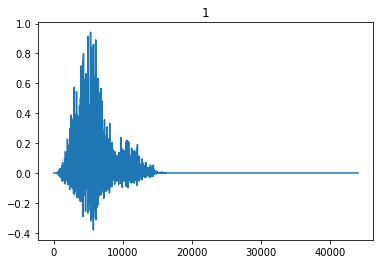

In [44]:
with tf.device('CPU:0'):
    test = part(np.reshape(data[4], (1, *data[0].shape)))
    plt.plot(test[0])
    plt.title(labels[4][0])

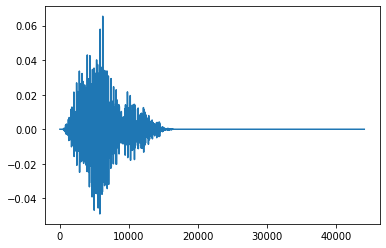

In [45]:
plt.plot(data[4])

In [26]:
data[4].shape, test[0].shape

((44100, 1), TensorShape([44100, 1]))

In [47]:
data[4][:10]

array([[7.0544370e-06],
       [8.1399785e-06],
       [7.3427418e-06],
       [7.3736433e-06],
       [6.6592497e-06],
       [7.3017163e-06],
       [7.6927154e-06],
       [8.5732818e-06],
       [8.4931708e-06],
       [8.8367933e-06]], dtype=float32)

In [49]:
test[0][:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[3.4643002e-05],
       [4.2362062e-05],
       [3.9482788e-05],
       [4.6658872e-05],
       [4.7001373e-05],
       [4.1737720e-05],
       [3.6244692e-05],
       [2.9912106e-05],
       [2.2517292e-05],
       [1.4997057e-05]], dtype=float32)>

In [46]:
ipd.Audio(data=np.reshape(test[0], (44100)), rate=44100)